In [1]:
# permite a utilização de caminhos relativos ao projeto, mesmo no diretório de notebooks

import numpy as np
import random
from knapsax.optimization import Knapsack
import matplotlib.pyplot as plt
from knapsax.pso import PSO
import time
from tqdm import tqdm
import tracemalloc

import pandas as pd
import seaborn as sns

from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [3]:
capacity = knapsack.capacity

values = [item.value for item in knapsack.items]
weights = [item.weight for item in knapsack.items]

# Resultados

In [4]:
pso = PSO(knapsack=knapsack, num_particles=20, inertia=0.99, c1=1.7, c2=1.7, n_iterations=1000,)

items, best_value, best_weight = pso.run()

In [5]:
resultados = []
for i in range(20):
    pso = PSO(knapsack, num_particles=20, inertia=0.99, c1=1.7, c2=1.7, n_iterations=1000)
    _, best_value, _ = pso.run()
    resultados.append(best_value)

resultados = np.array(resultados)
print(f"\nMédia: {np.mean(resultados):.2f}")
print(f"Desvio padrão: {np.std(resultados):.2f}")
print(f"Melhor valor: {np.max(resultados)}")
print(f"Pior valor: {np.min(resultados)}")


Média: 2175.05
Desvio padrão: 5.76
Melhor valor: 2188
Pior valor: 2167


In [6]:
print(f"Items: [{', '.join([f'Item(value={i.value}, weight={i.weight})' for i in items])}]")
print("Best Value:", best_value)
print("Weight:", best_weight)


Items: [Item(value=81, weight=58), Item(value=50, weight=35), Item(value=30, weight=15), Item(value=44, weight=28), Item(value=60, weight=45), Item(value=88, weight=66), Item(value=55, weight=40), Item(value=33, weight=23), Item(value=18, weight=12), Item(value=39, weight=25), Item(value=29, weight=21), Item(value=64, weight=48), Item(value=47, weight=33), Item(value=40, weight=27), Item(value=54, weight=39), Item(value=26, weight=18), Item(value=45, weight=29), Item(value=22, weight=14), Item(value=37, weight=24), Item(value=48, weight=32), Item(value=57, weight=42), Item(value=24, weight=17), Item(value=53, weight=38), Item(value=28, weight=20), Item(value=66, weight=51), Item(value=49, weight=34), Item(value=74, weight=61), Item(value=41, weight=26), Item(value=70, weight=57), Item(value=59, weight=44), Item(value=19, weight=13), Item(value=46, weight=30), Item(value=60, weight=46), Item(value=34, weight=22), Item(value=56, weight=41), Item(value=17, weight=11), Item(value=16, weigh

# Análise do comportamento médio

In [7]:
class Stats:
    def __init__(self, n_runs: int, algorithm_instance: object):
        self.n_runs = n_runs
        self.algorithm_instance = algorithm_instance
        self.data = {
            "iteration": [],
            "best_solution": [],
            "best_value": [],
            "best_weight": [],
            "history_value": [],
            "history_weight": [],
            "execution_time": [],
            "memory_peak": [],
            "memory_peak_mb": [],
        }

    def run(self):

        for i in tqdm(range(self.n_runs), desc="Running ACO", unit="run"):
            start_time = time.time()
            tracemalloc.start()
            best_solution, best_value, best_weight = self.algorithm_instance.run()
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_time = time.time()

            self.data["iteration"].append(i)
            self.data["best_solution"].append(best_solution)
            self.data["best_value"].append(best_value)
            self.data["best_weight"].append(best_weight)
            self.data["history_value"].append(self.algorithm_instance.history_value)
            self.data["history_weight"].append(self.algorithm_instance.history_weight)
            self.data["execution_time"].append(end_time - start_time)
            self.data["memory_peak"].append(peak)
            self.data["memory_peak_mb"].append(peak / 10**6)

    def frame(self):
        return pd.DataFrame(self.data)
    
    def plot_convergence(self, title: str, savefig: str = None):
        df = self.frame()

        value_by_run = np.array(df["history_value"].tolist())
        value_by_iteration = value_by_run.T

        means_by_iteration = np.mean(value_by_iteration, axis=1)
        std_by_iteration = np.std(value_by_iteration, axis=1)
        max_value = np.nanmax(value_by_iteration)

        fig, ax = plt.subplots(figsize=(10, 6))

        sns.lineplot(
            x=np.arange(len(means_by_iteration)),
            y=means_by_iteration,
            ax=ax,
            label="Média do custo",
            color="royalblue",
            linewidth=2.5
        )

        ax.fill_between(
            np.arange(len(means_by_iteration)),
            means_by_iteration - std_by_iteration,
            means_by_iteration + std_by_iteration,
            color="royalblue",
            alpha=0.2,
            label="Desvio padrão do custo"
        )

        ax.axhline(
            y=max_value,
            linestyle="--",
            color="forestgreen",
            linewidth=2,
            label=f"Valor máximo = {max_value}"
        )

        ax.set_title(title, fontsize=20)
        ax.set_xlabel("Iteração", fontsize=16)
        ax.set_ylabel("Custo", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        ax.legend(fontsize=12, frameon=True)
        plt.tight_layout()

        if savefig:
            plt.savefig(savefig, dpi=600)
        
        return fig, ax

In [8]:
pso_stats = Stats(n_runs=20, algorithm_instance=pso)
pso_stats.run()

Running ACO: 100%|██████████| 20/20 [01:05<00:00,  3.27s/run]


In [9]:
pso_stats.frame()

,iteration,best_solution,best_value,best_weight,history_value,history_weight,execution_time,memory_peak,memory_peak_mb
0,0,"[Item(value=81, weight=58), Item(value=50, wei...",2173,1550,"[1992, 1992, 1992, 1992, 1992, 1992, 1992, 199...","[1549, 1549, 1549, 1549, 1549, 1549, 1549, 154...",3.409158,144372,0.144372
1,1,"[Item(value=20, weight=16), Item(value=81, wei...",2181,1547,"[1946, 1946, 1946, 1946, 1946, 1946, 1946, 196...","[1548, 1548, 1548, 1548, 1548, 1548, 1548, 152...",3.933536,142740,0.142740
2,2,"[Item(value=81, weight=58), Item(value=50, wei...",2172,1550,"[1958, 1958, 1958, 1958, 1958, 1958, 1958, 195...","[1542, 1542, 1542, 1542, 1542, 1542, 1542, 154...",3.645175,143065,0.143065
3,3,"[Item(value=20, weight=16), Item(value=81, wei...",2174,1550,"[1923, 1923, 1973, 1973, 1973, 2037, 2037, 203...","[1546, 1546, 1491, 1491, 1491, 1543, 1543, 154...",3.704919,143433,0.143433
4,4,"[Item(value=81, weight=58), Item(value=30, wei...",2176,1550,"[1911, 1922, 1922, 1961, 1961, 1961, 1961, 196...","[1541, 1488, 1488, 1521, 1521, 1521, 1521, 152...",3.497629,143073,0.143073
5,5,"[Item(value=81, weight=58), Item(value=50, wei...",2164,1550,"[1984, 1984, 1984, 1984, 1984, 1984, 1984, 198...","[1549, 1549, 1549, 1549, 1549, 1549, 1549, 154...",3.034351,143209,0.143209
6,6,"[Item(value=20, weight=16), Item(value=81, wei...",2175,1550,"[1978, 1978, 1978, 1978, 2005, 2005, 2029, 202...","[1547, 1547, 1547, 1547, 1520, 1520, 1541, 154...",2.826527,143633,0.143633
7,7,"[Item(value=20, weight=16), Item(value=81, wei...",2174,1550,"[1948, 1948, 1948, 1948, 1948, 1948, 1948, 194...","[1550, 1550, 1550, 1550, 1550, 1550, 1550, 155...",2.877458,143113,0.143113
8,8,"[Item(value=81, weight=58), Item(value=50, wei...",2179,1546,"[1975, 1975, 1975, 1975, 1975, 1975, 1975, 197...","[1547, 1547, 1547, 1547, 1547, 1547, 1547, 154...",3.064103,143001,0.143001
9,9,"[Item(value=81, weight=58), Item(value=50, wei...",2181,1549,"[1902, 1902, 1902, 1902, 1916, 1916, 1956, 195...","[1547, 1547, 1547, 1547, 1535, 1535, 1544, 154...",3.175651,144177,0.144177


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Convergência do PSO'}, xlabel='Iteração', ylabel='Custo'>)

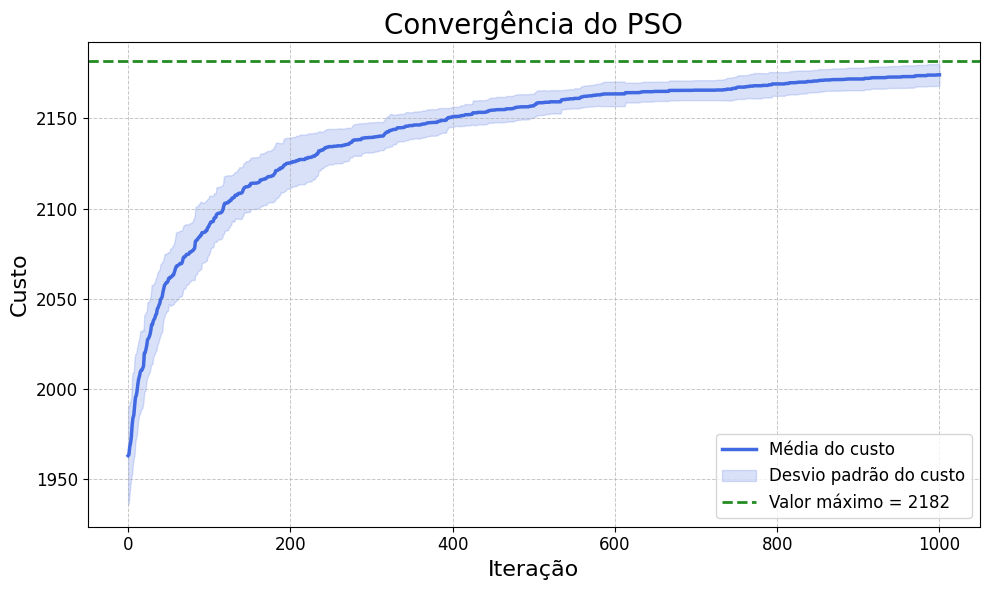

In [10]:
pso_stats.plot_convergence(
    title="Convergência do PSO",
    savefig="results/pso_convergence.png"
)